## Convolutional Neural Networks (CNN)

### GPU selection

Select the GPU id to use.

In [1]:
# Select the right device. Change the number to select a different GPU.
device_id = 0

In [2]:
import torch
from torch import cuda
from multiprocessing import cpu_count

# Automatic device selection
if cuda.is_available():
    torch.set_num_threads(cpu_count() // cuda.device_count())
    device = torch.device(f"cuda:{device_id}")
else:
    torch.set_num_threads(cpu_count())
    device = torch.device("cpu")
device

device(type='cuda', index=0)

### Hyperparameters

These are the hyperparameters used throughout this chapter. Placed here for
easier experiments.

There are too many hyperparameters to save as plain variables, so let's group
them into one `params` dictionary.

In [3]:
from torch import nn, optim

params = {
    # Training hyperparams
    "batch_size": 128,
    "epochs": 20,
    # Model hyperparams
    "num_layers": 3,
    "input_kernel": 3,
    "hidden_channel": 32,
    "hidden_kernel": 5,
    "batchnorm": True,
    "pooling": "max",    # None, "max", "avg"
    "pooling_size": 2,   # only used if pooling is not None
    "Activation": nn.ReLU,
    # Optimizer hyperparams
    "Optimizer": optim.Adam,
    "lr": 1e-4,
    # Extra
    "print_every": 4,
}

### Data preprocessing

This code is mostly taken from the previous chapter.


In [4]:
import torchvision as tv
from torch.utils.data import DataLoader
from PIL import Image
from IPython.display import clear_output


# PyTorch provides the MNIST dataset in the torchvision library, but it is not
# optimized for GPU. To speed up training, we will use a subclass of the
# torchvision.datasets.MNIST to load the data into the memory.
class MNIST_GPU(tv.datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.data = torch.cat([tv.transforms.F.to_tensor(
            Image.fromarray(img.numpy())) for img in self.data])

    # All datasets should provide an interface to get a sample (__getitem__
    # magic method). This is commonly referred to as an "operator overloading".
    def __getitem__(self, i):
        return self.data[i], self.targets[i]

    # Also, they should provide the __len__ magic method. However, the MNIST
    # class already implements it, so we could just use it via inheritance.
    # def __len__(self):
    #     return len(self.data)

    # This is just for convinience.
    def to(self, device):
        self.data = self.data.to(device)
        self.targets = self.targets.to(device)
        return self


def mnist_dataset(train: bool):
    dataset = MNIST_GPU("resources/", train=train, download=True)
    clear_output(wait=True)
    return dataset.to(device)


def to_dataloader(dataset: MNIST_GPU):
    return DataLoader(dataset,
                      batch_size=params["batch_size"],
                      shuffle=dataset.train)


train_set, valid_set = mnist_dataset(True), mnist_dataset(False)
H, W = train_set[0][0].shape[-2:]

### CNN model

CNN can handle 2 (or even higher) dimensional data natively, so there is no need
to "flatten" the pictures from the MNIST dataset as we did in the previous
chapter.

However, we need to consider two more new aspects: padding and batch
normalization.

- Padding: If kernel size, stride, or dilation of a convolutional layer is not
  1, the output "figure" size will be smaller than the input. Thus, we must
  increase the figure size before feeding the data into the convolutional layer
  to preserve the size. _Padding_ can do such job by filling the edges of a
  figure by some value (mostly 0).
- Batch normalization: As opposed to the linear layer, a convolutional layer
  re-uses its kernel (i.e., model parameters) over the entire figure. Dropout,
  which effectively zeroes out some specific positions of a figure, is thus
  ineffective to prevent the overfitting problem.

  Now, it's time to introduce
  [_batch normalization_](https://en.wikipedia.org/wiki/Batch_normalization). It
  is a rescaling/recentering operation over the minibatch, allowing more stable
  training and suppressing overfitting problem.

#### Implementing the "same" padding

PyTorch does not provide an automatic padding scheme to preserve the input size
(before 1.9). Fortunately, a layer mimicing such behavior is quite easy to
implement.

The output size of a convolutional layer is defined by the following formula, as
per the
[PyTorch docs](https://pytorch.org/docs/1.8.1/generated/torch.nn.Conv2d.html).
Here, $o$, $i$, $p$, $d$, $k$, and $s$ are the output size, input size, padding,
dilation, kernel size, and stride, respectively.

$$
o = \lfloor \frac{i + 2p - d \times (k - 1) - 1}{s} + 1 \rfloor
$$

Thus, the padding required to ensure $o = i$ is

$$
p = \frac {d \times (k - 1) + (s - 1) \times (i - 1)}{2}
$$

Bad story: if $s \ne 1$, the padding depends on the input size. To simplify, we
assume stride 1. Then the $i$ term is removed:

$$
p = \frac {d \times (k - 1)}{2}
$$

Much better! So, the best way to keep the input size is to set the dilation an
even number or the kernel size an odd number. Let's take the latter throughout
this chapter, and just fix the dilation 1. Also, we'll assume the kernel is a
square, i.e., kernel height and width are the same.

**Side Note**: We don't necessarily **have** to keep the figure size same
throughout layers, but this is the easiest way to calculate the final output
dimension size.


In [5]:
class SamePad2d(nn.Module):
    def __init__(self, kernel_size: int):
        super().__init__()

        size = (kernel_size - 1) // 2
        # If kernel_size is even, we need to make it odd by adding an extra
        # padding at the right and the bottom.
        # This behavior is taken from the PyTorch >= 1.9 implementation.
        if not kernel_size % 2:
            size = (size, size + 1, size, size + 1)
        self.padding = nn.ZeroPad2d(size)

    def forward(self, x):
        return self.padding(x)

#### Padding before pooling layers

Padding layers before pooling layers are slightly different. The pooling layers
have the same kernel size and stride; the "same" pooling would result in a
$\lfloor (i - 1) / s + 1 \rfloor$ sized output. Still, the padding is used before the
padding layers, to preserve the data near the edges.

#### Main model

This is our main model.

In [6]:
import math


class CNN(nn.Module):
    def __init__(self, params: dict):
        super().__init__()
        self.num_layers = params["num_layers"]
        self.input_kernel = params["input_kernel"]
        self.hidden_channel = params["hidden_channel"]
        self.hidden_kernel = params["hidden_kernel"]

        self.pooling = params["pooling"]
        self.pooling_size = params["pooling_size"]

        self.activation = params["Activation"]()
        self.batchnorm = params["batchnorm"]

        if self.num_layers < 1:
            raise ValueError("num_layers must be >= 1")

        # Convolutional layers
        layers: list[nn.Module] = [self._block(1,
                                               self.hidden_channel,
                                               self.input_kernel)]
        for _ in range(self.num_layers - 1):
            layers.append(self._block(self.hidden_channel,
                                      self.hidden_channel,
                                      self.hidden_kernel))

        # Flatten the output of the last convolutional layer
        layers.append(nn.Flatten())

        # Linear projection to the output
        out_H, out_W = self._output_size(H), self._output_size(W)
        layers.append(nn.Linear(out_H * out_W * self.hidden_channel, 10))

        self.net = nn.Sequential(*layers)

    def forward(self, X):
        # Q) Why unsqueeze the first dimension?
        return self.net(X.unsqueeze(1))

    def _block(self, in_channels, out_channels, kernel_size):
        layers = [SamePad2d(kernel_size),
                  nn.Conv2d(in_channels, out_channels, kernel_size)]

        if self.pooling is not None:
            layers.append(SamePad2d(self.pooling_size))
            if self.pooling == "max":
                layers.append(nn.MaxPool2d(self.pooling_size))
            elif self.pooling == "avg":
                layers.append(nn.AvgPool2d(self.pooling_size))
            else:
                raise ValueError("Unknown pooling method")

        # Activation usually after pooling
        layers.append(self.activation)

        # Batchnorm usually after activation
        if self.batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))

        return nn.Sequential(*layers)

    def _output_size(self, input_size):
        def per_layer(input_size):
            return math.floor((input_size - 1) / self.pooling_size + 1)

        out_size = input_size
        if self.pooling is not None:
            for _ in range(self.num_layers):
                out_size = per_layer(out_size)
        return out_size

### Training and validation code

These too are imported but contain some changes. Figure out the differences!

In [7]:
from torch.nn import functional as F

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from collections import defaultdict

sns.set_theme(style="whitegrid", palette="muted")


@torch.no_grad()
def accuracy(y_hat: torch.Tensor, y: torch.Tensor):
    return (y_hat.argmax(dim=1) == y).float().mean()


def run(model: nn.Module, loader: DataLoader, callbacks: dict):
    def callback_if_registered(name: str, *args):
        try:
            callbacks[name](*args)
        except KeyError:
            pass

    callback_if_registered("on_epoch_begin")

    epoch_loss = []
    epoch_accu = []

    for X, y in loader:
        callback_if_registered("on_batch_begin")

        # Shape: [B, H, W] -> [B, C]
        y_hat = model(X)
        # calculate loss
        loss = F.cross_entropy(y_hat, y)

        callback_if_registered("on_batch_end", loss)

        epoch_loss.append(loss.item())
        epoch_accu.append(accuracy(y_hat, y))

    return torch.tensor(epoch_loss).mean(), torch.tensor(epoch_accu).mean()


def train(model: nn.Module, loader: DataLoader, optimizer: optim.Optimizer):
    def on_batch_end(loss: torch.Tensor):
        loss.backward()
        optimizer.step()

    callbacks = {
        "on_epoch_begin": lambda: model.train(),
        "on_batch_begin": lambda: optimizer.zero_grad(),
        "on_batch_end": on_batch_end,
    }

    return run(model, loader, callbacks)


@torch.no_grad()
def validate(model: nn.Module, loader: DataLoader):
    callbacks = {
        "on_epoch_begin": lambda: model.eval(),
    }

    return run(model, loader, callbacks)


def train_cnn(model: nn.Module,
              train_loader: DataLoader, valid_loader: DataLoader):
    optimizer = params["Optimizer"](model.parameters(), lr=params["lr"])
    stats = defaultdict(list)

    for epoch in trange(1, params["epochs"] + 1):
        train_loss, train_accu = train(model, train_loader, optimizer)
        valid_loss, valid_accu = validate(model, valid_loader)

        stats["epoch"] += [epoch] * 4
        stats["run"] += ["train", "train", "valid", "valid"]
        stats["type"] += ["loss", "accuracy"] * 2
        stats["stat"] += [train_loss, train_accu, valid_loss, valid_accu]

        if not epoch % params["print_every"]:
            tqdm.write((f"{train_loss = :.4f}, {train_accu = :.2%}, "
                        f"{valid_loss = :.4f}, {valid_accu = :.2%}"))

    return stats

And here are some utility functions:

In [10]:
def get_dataloaders():
    return to_dataloader(train_set), to_dataloader(valid_set)


def print_model_summary(model: nn.Module):
    param_cnt = sum(param.numel()
                    for param in model.parameters() if param.requires_grad)

    print(model)
    print(f"Model has {param_cnt:,} trainable parameters")


def plot_stats(stats: dict):
    for k, v in stats.items():
        stats[k] = np.array(v)

    sns.relplot(x="epoch", y="stat", data=stats,
                hue="run", col="type", kind="line",
                facet_kws={"sharey": False, "xlim": (0, params["epochs"])})
    plt.show()

### Model training and hyperparameter optimization

Now it's your turn. Get back to the beginning of this notebook, and change the
hyperparameters. Run the following cell again and again until the best
combination (i.e., the combination with the highest validation accuracy) is
found. Good luck!

CNN(
  (activation): ReLU()
  (net): Sequential(
    (0): Sequential(
      (0): SamePad2d(
        (padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): SamePad2d(
        (padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): SamePad2d(
        (padding): ZeroPad2d(padding=(2, 2, 2, 2), value=0.0)
      )
      (1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (2): SamePad2d(
        (padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequentia

  0%|          | 0/20 [00:00<?, ?it/s]

train_loss = 0.0367, train_accu = 99.12%, valid_loss = 0.0374, valid_accu = 98.87%
train_loss = 0.0119, train_accu = 99.83%, valid_loss = 0.0292, valid_accu = 99.14%
train_loss = 0.0035, train_accu = 99.99%, valid_loss = 0.0258, valid_accu = 99.14%
train_loss = 0.0010, train_accu = 100.00%, valid_loss = 0.0264, valid_accu = 99.17%
train_loss = 0.0004, train_accu = 100.00%, valid_loss = 0.0271, valid_accu = 99.17%


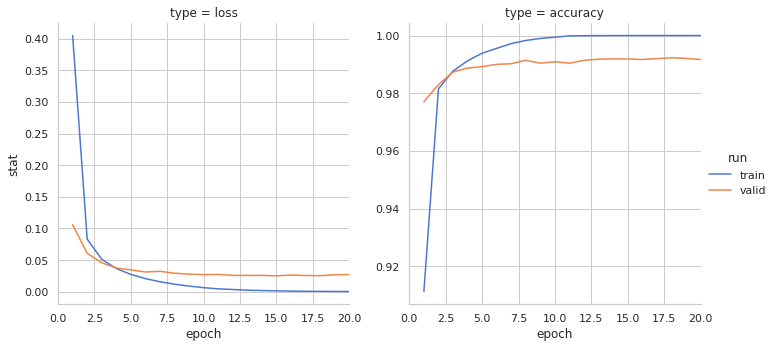

In [11]:
train_loader, valid_loader = get_dataloaders()

model = CNN(params).to(device)
# Visualize the model
print_model_summary(model)

stats = train_cnn(model, train_loader, valid_loader)
plot_stats(stats)